## Configuration

The configuration is the design of the neural network, it has the following parameters:  

1. loss: this is the metric for the loss function, and it can be: 'mse'=mean squared error (for continuous data), or 'ce' for cross entropy (for binary data)
2. distance_metric: this is the distance metric between the distributions and can either be 'mmd': maximum mean discrepency, or kl: Kullback–Leibler (see this blog for details: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/)
3. mmd_weight: this is how much you want to force the VAE to learn 

We're going to use two types of VAEs, 1 a normal VAE for the numeric quality data, 2 a conv VAE for the sequence data. To make the training data for the Conv VAE we want to one hot encode it such that each entry is is the sequence

e.g. our kmer would look like this if it was ATACAAC
```
A|1 0 1 0 1 1 0|
T|0 1 0 0 0 0 0|
G|0 0 0 0 0 0 0|
C|0 0 0 1 0 0 1| 
```
We want to do this with a filter that goes across 2 or more columns at once that we we can capture the spatial information. So we need to one hot encode in a special way (i.e. to make the columns)

In [10]:
import os
output_folder = '../runs/'
runs = os.listdir(output_folder)

e_plus_ecoli = ['SRR12090426', 'SRR12090427', 'SRR12090428']
e_minus_ecoli = ['SRR12090429', 'SRR12090430']
s_plus_ecoli = ['SRR12090431', 'SRR12090432', 'SRR12090433']
s_minus_ecoli = ['SRR12090434', 'SRR12090435']


species_runs = e_plus_ecoli + e_minus_ecoli + s_plus_ecoli + s_minus_ecoli

bams = [f'{output_folder}{run}' for run in runs if '.bai' not in run and '_genome.sorted' not in run and 'bam' in run]
bams = [b for b in bams if b.split('/')[-1].split('.')[0] in species_runs]
bams

['../runs/SRR12090435.sorted.bam',
 '../runs/SRR12090430.sorted.bam',
 '../runs/SRR12090427.sorted.bam',
 '../runs/SRR12090432.sorted.bam',
 '../runs/SRR12090426.sorted.bam',
 '../runs/SRR12090433.sorted.bam',
 '../runs/SRR12090429.sorted.bam',
 '../runs/SRR12090434.sorted.bam',
 '../runs/SRR12090431.sorted.bam',
 '../runs/SRR12090428.sorted.bam']

## Count reads to genes

In [13]:
import pandas as pd

ecoli_info = pd.read_csv(f'{output_folder}{species_runs[0]}.csv')
ecoli_info['gtf_file'].values[0]

'/media/WorkingSpace/Ariane/output/bacteria/genomes/GCF_000005845.2_ASM584v2_genes-RNA.gff'

In [15]:
from scibacr import *
gtf = ecoli_info['gtf_file'].values[0]
fasta = ecoli_info['reference_fasta_path'].values[0].replace('.fna', '_transcripts.fasta')
# ID=gene-b0941;Dbxref=ASAP:ABE-0003191,ECOCYC:G6483,GeneID:947185;Name=elfG;gbkey=Gene;gene=elfG;gene_biotype=protein_coding;gene_synonym=ECK0932,ycbT;locus_tag=b0941

count_df = count_reads(bams, gtf, info_cols=['gene', 'gene_biotype'])
count_df

../runs/SRR12090435.sorted.bam 43328 429722 0.9084071451220801
../runs/SRR12090430.sorted.bam 45449 355580 0.8866690438846069
../runs/SRR12090427.sorted.bam 104110 592808 0.850613702042421
../runs/SRR12090432.sorted.bam 33366 503409 0.937839877043454
../runs/SRR12090426.sorted.bam 49173 429516 0.8972756842125054
../runs/SRR12090433.sorted.bam 56906 558937 0.9075965789982187
../runs/SRR12090429.sorted.bam 33360 275673 0.8920503635534069
../runs/SRR12090434.sorted.bam 35270 445611 0.9266554511407188
../runs/SRR12090431.sorted.bam 57363 541814 0.9042636816833757


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,gene,id,gene,gene_biotype,SRR12090435,SRR12090430,SRR12090427,SRR12090432,SRR12090426,SRR12090433,SRR12090429,SRR12090434,SRR12090431,SRR12090428
0,gene-b0941,NC_000913.3:1001806-1002877,elfG,protein_coding,3,0,5,2,2,5,0,3,2,2
1,gene-b0942,NC_000913.3:1002888-1003431,ycbU,protein_coding,0,0,1,3,2,0,0,0,0,1
2,gene-b0943,NC_000913.3:1003438-1003954,ycbV,protein_coding,0,2,0,2,1,2,0,3,3,1
3,gene-b0944,NC_000913.3:1003946-1004657,ycbF,protein_coding,4,3,7,7,3,10,2,10,9,7
4,gene-b0945,NC_000913.3:1004767-1005778,pyrD,protein_coding,2,1,8,0,3,1,1,1,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4490,gene-b0090,NC_000913.3:99643-100711,murG,protein_coding,45,36,58,54,53,52,29,41,44,40
4491,gene-b0937,NC_000913.3:996936-997512,ssuE,protein_coding,1,1,3,0,0,4,1,1,2,1
4492,gene-b0938,NC_000913.3:997867-998407,elfA,protein_coding,0,1,1,6,0,7,0,3,2,2
4493,gene-b0939,NC_000913.3:998489-999191,elfD,protein_coding,0,0,0,0,0,1,0,0,1,0


(array([707., 459., 413., 548., 547., 540., 436., 315., 214., 136.,  92.,
         44.,  15.,  11.,   8.,   3.,   4.,   1.,   0.,   2.]),
 array([ 0.        ,  0.82701125,  1.65402249,  2.48103374,  3.30804499,
         4.13505623,  4.96206748,  5.78907872,  6.61608997,  7.44310122,
         8.27011246,  9.09712371,  9.92413496, 10.7511462 , 11.57815745,
        12.40516869, 13.23217994, 14.05919119, 14.88620243, 15.71321368,
        16.54022493]),
 <BarContainer object of 20 artists>)

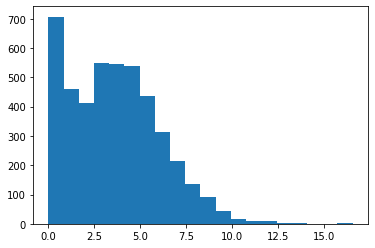

In [16]:
mean_counts = np.mean(count_df[[c for c in count_df.columns if 'SRR' in c]], axis=1)
plt.hist(np.log2(mean_counts + 1), bins=20)

In [19]:
count_df_nn = count_df[mean_counts > 2.5]
# Drop any genes that didn't have any counts then save
count_df_nn.to_csv(f'{output_folder}counts_abundent.csv', index=False)


In [20]:
count_df_nn

,gene,id,gene,gene_biotype,SRR12090435,SRR12090430,SRR12090427,SRR12090432,SRR12090426,SRR12090433,SRR12090429,SRR12090434,SRR12090431,SRR12090428
3,gene-b0944,NC_000913.3:1003946-1004657,ycbF,protein_coding,4,3,7,7,3,10,2,10,9,7
4,gene-b0945,NC_000913.3:1004767-1005778,pyrD,protein_coding,2,1,8,0,3,1,1,1,5,9
5,gene-b0946,NC_000913.3:1005951-1006494,zapC,protein_coding,34,27,51,45,33,58,17,42,66,33
6,gene-b0947,NC_000913.3:1006490-1007600,ycbX,protein_coding,14,6,26,17,9,23,8,14,29,16
7,gene-b0091,NC_000913.3:100764-102240,murC,protein_coding,63,71,125,90,78,104,51,96,99,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,gene-b0930,NC_000913.3:987584-988985,asnS,protein_coding,254,57,181,171,57,298,43,202,323,157
4483,gene-b0931,NC_000913.3:989153-990356,pncB,protein_coding,35,16,63,15,20,46,14,27,57,48
4484,gene-b0932,NC_000913.3:990621-993234,pepN,protein_coding,167,230,265,212,220,241,124,209,233,180
4485,gene-b0010,NC_000913.3:9927-10494,satP,protein_coding,19,9,20,14,6,34,2,11,30,19


## Write a MSA so we can double check the choices make sense

In [ ]:
species_columns = [c for c in count_df.columns if 'SRR' in c]
species_df = count_df_nn[['id', 'species'] + species_columns]

min_counts = np.min(species_df[species_columns].values, axis=1)
# Get the genes that had at least 30 counts in each...
species_df = species_df[min_counts > 30]
gene_location = 'GB_GCA_014170915.1~CP059988.1-#2' # psi is at 512.
ref = pysam.FastaFile(f'{genome_dir}ssu_all_r207_gr1400.fna')
for bam in bams:
    samfile = pysam.AlignmentFile(f'{bam}', "rb")
    write_msa_over_gene(gene_location, samfile, ref, f'{output_folder}msas/{bam.split("/")[-1].split(".")[0]}.msa',
                        read_dict=read_dict)
    samfile.close()

## Create the h5 files that will be used for training and testing

In [26]:
fasta = ecoli_info['reference_fasta_path'].values[0].replace('.fna', '_transcripts.fasta')

for bam in bams:
    print(bam)
    read_dict = gen_mapping_gene_read_dict(bam, gtf)
    output_name = f'{output_folder}training_new/{bam.split("/")[-1].split(".")[0]}_training.h5'
    gen_training_h5py_position(bam, fasta, read_dict,
                                   output_filename=output_name,
                                   min_coverage=20, max_coverage=100)

../runs/SRR12090435.sorted.bam


 34%|▎| 1282/3781 [06:54<01:25, 29.17

SRR12090435.252122
SRR12090435.436395
SRR12090435.269839


 59%|▌| 2224/3781 [09:23<00:45, 34.45

SRR12090435.200921
SRR12090435.204323


100%|█| 3781/3781 [11:28<00:00,  5.49


../runs/SRR12090430.sorted.bam


 11%| | 393/3525 [00:08<00:44, 71.17i

SRR12090430.402760


 57%|▌| 2018/3525 [04:40<00:55, 27.30

SRR12090430.317995
SRR12090430.295467
SRR12090430.587799
SRR12090430.293498


100%|█| 3525/3525 [13:55<00:00,  4.22


../runs/SRR12090427.sorted.bam


 59%|▌| 2212/3775 [26:05<01:09, 22.43

SRR12090427.756519
SRR12090427.919814
SRR12090427.371356
SRR12090427.684725


100%|█| 3775/3775 [29:51<00:00,  2.11


../runs/SRR12090432.sorted.bam


 33%|▎| 1251/3737 [15:04<17:25,  2.38i

SRR12090432.325272
SRR12090432.560352
SRR12090432.260549
SRR12090432.817761


100%|█| 3737/3737 [23:35<00:00,  2.64i


../runs/SRR12090426.sorted.bam


 12%| | 409/3538 [00:09<00:59, 52.71it

SRR12090426.494342


 58%|▌| 2040/3538 [05:05<00:54, 27.30i

SRR12090426.90739
SRR12090426.519734
SRR12090426.204787
SRR12090426.136574
SRR12090426.286649
SRR12090426.740934
SRR12090426.857337
SRR12090426.470211
SRR12090426.667643


100%|█| 3538/3538 [18:47<00:00,  3.14i


../runs/SRR12090433.sorted.bam


 33%|▎| 1284/3853 [15:08<02:47, 15.36i

SRR12090433.387880
SRR12090433.805993
SRR12090433.756518


 58%|▌| 2249/3853 [18:01<00:59, 27.15i

SRR12090433.977792
SRR12090433.992393


100%|█| 3853/3853 [19:44<00:00,  3.25i


../runs/SRR12090429.sorted.bam


 57%|▌| 1939/3387 [04:46<00:53, 26.84i

SRR12090429.122840
SRR12090429.99144
SRR12090429.271483
SRR12090429.444496
SRR12090429.425939


100%|█| 3387/3387 [07:21<00:00,  7.68i


../runs/SRR12090434.sorted.bam


 33%|▎| 1233/3715 [06:32<07:01,  5.89i

SRR12090434.383554
SRR12090434.73554


100%|█| 3715/3715 [15:02<00:00,  4.11i


../runs/SRR12090431.sorted.bam


 34%|▎| 1291/3842 [11:11<02:50, 14.94i

SRR12090431.277134
SRR12090431.457812
SRR12090431.684267
SRR12090431.956707
SRR12090431.789191


 58%|▌| 2240/3842 [15:01<00:51, 31.29i

SRR12090431.837437
SRR12090431.774440
SRR12090431.541798
SRR12090431.703905


100%|█| 3842/3842 [16:34<00:00,  3.86i


../runs/SRR12090428.sorted.bam


 33%|▎| 1205/3692 [12:15<09:25,  4.40i

SRR12090428.106822
SRR12090428.602086
SRR12090428.704569
SRR12090428.818327
SRR12090428.860942
SRR12090428.95585


100%|█| 3692/3692 [29:33<00:00,  2.08i


## Create a training dataset

Here we create a chunked dataset that can be used to train from a single WT sample.

In [28]:
training_run = f'{output_folder}training_new/SRR12090434_training.h5' # Use a S-minus sample
kmer_len = 5
training_df = create_train_chunked_set([training_run], kmer_len)
training_df

,Run,Gene,ID,Start,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,../runs/training_new/SRR12090434_training.h5,NC_000913.3:1005951-1006494,0,0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.0,0.0,23.0,0.0,0.0,0.0,10.0,0.0
1,../runs/training_new/SRR12090434_training.h5,NC_000913.3:1005951-1006494,1,5,24.0,17.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2,../runs/training_new/SRR12090434_training.h5,NC_000913.3:1005951-1006494,2,10,6.0,7.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,18.0,0.0
3,../runs/training_new/SRR12090434_training.h5,NC_000913.3:1005951-1006494,3,15,0.0,30.0,0.0,0.0,12.0,0.0,...,26.0,0.0,0.0,27.0,0.0,0.0,0.0,19.0,0.0,0.0
4,../runs/training_new/SRR12090434_training.h5,NC_000913.3:1005951-1006494,4,20,0.0,26.0,29.0,0.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369377,../runs/training_new/SRR12090434_training.h5,NC_000913.3:99643-100711,93,465,0.0,13.0,16.0,0.0,0.0,0.0,...,15.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0
1369378,../runs/training_new/SRR12090434_training.h5,NC_000913.3:99643-100711,94,470,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,25.0,0.0,15.0,23.0,0.0,0.0,0.0,0.0,0.0
1369379,../runs/training_new/SRR12090434_training.h5,NC_000913.3:99643-100711,95,475,0.0,0.0,15.0,16.0,0.0,0.0,...,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
1369380,../runs/training_new/SRR12090434_training.h5,NC_000913.3:99643-100711,96,480,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17.0,27.0,0.0,18.0,13.0,0.0,0.0,0.0


## Get k-mers across the 16s genes

We want to do a sliding window to have a look at the kmers across a gene.

This will allow us to actually do the searchy thing properly and see if the tails of the distributions enable the identification of the modifications in KO.

In [29]:
count_df_nn = count_df[mean_counts > 10]
genes = list(set(count_df_nn['id'].values))

gen_kmer_sliding_window_ref(fasta, 5, f'{output_folder}kmer_5_bac.h5', genes)

In [30]:
from collections import defaultdict
kmer_counts = defaultdict(int)
kmer_h5 = h5py.File(f'{output_folder}kmer_5_bac.h5', 'r')
for kmer in kmer_h5:
    kmer_data = kmer_h5[kmer]
    for k in kmer_data.keys():
        #for position in kmer_data[k]:
        kmer_counts[kmer] += 1
kmer_h5.close()

In [31]:
dict(sorted(kmer_counts.items(), key=lambda item: item[1], reverse=True))

{'GCCAG': 1864,
 'CGCCA': 1855,
 'CAGCG': 1846,
 'CTGGC': 1840,
 'CCAGC': 1818,
 'CAGCA': 1817,
 'CGCTG': 1805,
 'TGGCG': 1797,
 'TGCTG': 1795,
 'GCTGG': 1774,
 'CGGCA': 1770,
 'TGCCG': 1765,
 'GCGCA': 1757,
 'ATCGC': 1756,
 'TGCGC': 1747,
 'GCTGC': 1745,
 'GCAGC': 1744,
 'GCGAT': 1740,
 'CGGCG': 1732,
 'GCCGC': 1729,
 'GCGGC': 1729,
 'TCAGC': 1729,
 'CGCCG': 1719,
 'TTGCC': 1719,
 'GCGCG': 1713,
 'TCGCC': 1708,
 'CGCGC': 1706,
 'TTTGC': 1704,
 'GGCAA': 1703,
 'CGCAG': 1702,
 'GGCGA': 1695,
 'CATCA': 1691,
 'GCCTG': 1690,
 'GCGTT': 1690,
 'AACGC': 1680,
 'GCAAA': 1679,
 'TGGCA': 1677,
 'ACCGC': 1670,
 'TGCCA': 1664,
 'CTGCG': 1663,
 'CAGGC': 1658,
 'TGATG': 1653,
 'GCTGA': 1646,
 'AGCGC': 1645,
 'CACCG': 1641,
 'TGGTG': 1641,
 'GCGCT': 1637,
 'CTGGT': 1634,
 'ACGCC': 1624,
 'CACCA': 1624,
 'CCTGC': 1622,
 'ACCAG': 1620,
 'GCAGG': 1618,
 'CAGAA': 1616,
 'GCGCC': 1610,
 'GCAGA': 1609,
 'GCTTT': 1609,
 'GGCGT': 1607,
 'ATCAG': 1605,
 'TTCAG': 1605,
 'GGCAG': 1603,
 'TTCGC': 1602,
 'GCGAA'

## Use the training df to train a VAE

In [32]:
training_df.to_csv(f'{output_folder}training_data.csv', index=False)
# Now we need to replcae the deletions, let's replace with 0 for now, sometimes I do mean...
training_df = training_df.replace(np.nan, 0) # 

test_data = training_df.values[:, 4:]
test_data = test_data / np.max(test_data)
test_data = np.array(test_data).astype(float)
test_labels = training_df[: 1]

In [36]:
from scivae import ConvVAE
config = {'scale_data': False,
         'input_size': (4, kmer_len),
          'batch_norm': True,
         'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 0.1},
          'encoding': {'layers': [{'filters': 32, 'kernel_size': 4, 'pooling': 2, 'strides': 1, 'padding':'same',
                                  'activation_fn': 'relu'},
                                  ]},
          'decoding': {'layers': [
                                  {'filters': 32, 'kernel_size': 4, 'pooling': 2, 'strides': 2, 'padding':'same',
                                  'activation_fn': 'relu'},
                                  {'filters': 1, 'kernel_size': 4, 'pooling': 2, 'strides': 1, 'padding':'same',
                                  'activation_fn': 'sigmoid'}
                                  ]},
          'latent': {'num_nodes': 1},
          'optimiser': {'params': {'learning_rate': 0.01}, 'name': 'adam'}
}

test_data = np.array([d.reshape((4, kmer_len, 1)) for d in test_data])
# Run the VAE 
cvae = ConvVAE(test_data, test_data, test_labels, config, 'cvae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
cvae.encode('default', epochs=100, batch_size=16, early_stop=True)
# get the encoded data
seq_encoding = cvae.get_encoded_data()


(4, 5)
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input (InputLayer)     [(None, 4, 5, 1)]    0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 4, 5, 32)     544         ['default_input[0][0]']          
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 4, 5, 32)    128         ['conv2d_1[0][0]']               
 rmalization)                           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72749/72749 [==============================] - 193s 3ms/step - loss: 0.0682 - val_loss: 0.0680
Epoch 18/100
 8270/72749 [==>...........................] - ETA: 2:39 - loss: 0.0680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72749/72749 [==============================] - 193s 3ms/step - loss: 0.0680 - val_loss: 0.0680
Epoch 21/100
 4316/72749 [>.............................] - ETA: 2:49 - loss: 0.0682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72749/72749 [==============================] - 193s 3ms/step - loss: 0.0680 - val_loss: 0.0679
Epoch 23/100
60845/72749 [========================>.....] - ETA: 29s - loss: 0.0680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72749/72749 [==============================] - 194s 3ms/step - loss: 0.0679 - val_loss: 0.0678
Epoch 26/100
55546/72749 [=====================>........] - ETA: 42s - loss: 0.0679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72749/72749 [==============================] - 194s 3ms/step - loss: 0.0679 - val_loss: 0.0679
Epoch 29/100
50490/72749 [===================>..........] - ETA: 55s - loss: 0.0679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72749/72749 [==============================] - 194s 3ms/step - loss: 0.0678 - val_loss: 0.0677
Epoch 32/100
46182/72749 [==================>...........] - ETA: 1:06 - loss: 0.0678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72749/72749 [==============================] - 194s 3ms/step - loss: 0.0678 - val_loss: 0.0676
Epoch 35/100
38887/72749 [===============>..............] - ETA: 1:23 - loss: 0.0677

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72749/72749 [==============================] - 194s 3ms/step - loss: 0.0677 - val_loss: 0.0677
Epoch 38/100
25520/72749 [=========>....................] - ETA: 1:57 - loss: 0.0676

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



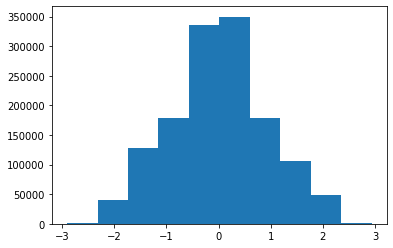

/tmp/ipykernel_1216511/3984487467.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])


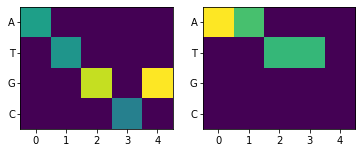

42794/42794 [==============================] - 41s 961us/step


/tmp/ipykernel_1216511/3984487467.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])


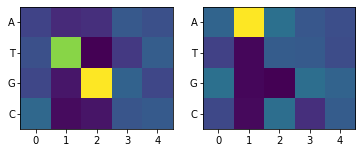

In [37]:
import matplotlib.pyplot as plt
plt.hist(seq_encoding)  # Has a nice normal dist
plt.show()

# Show some of the kmers (4)
n = 2
seqs_encoding = cvae.get_encoded_data()
# Show the true data
plt.figure(figsize=(6, 3))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])
    ax.tick_params(axis='y', which='major', pad=2.0)
    plt.imshow(test_data[i].reshape(4, kmer_len))

plt.show()

# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
d = cvae.decoder.predict(seqs_encoding)

plt.figure(figsize=(6, 3))
n = 2
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])
    ax.tick_params(axis='y', which='major', pad=2.0)
    plt.imshow(d[i,:].reshape(4, kmer_len))
plt.show()

In [38]:
cvae.save(f'model_weights_{kmer_len}.h5', f'model_optimiser_{kmer_len}.json', f'config_{kmer_len}.json') # looks pretty decent for a single node 

## Use encoding function to probe for variation in the dataset


(array([  8.,   2.,   2.,  12.,  15.,  35.,  46.,  46.,  63.,  61.,  70.,
         83., 101., 114.,  98., 101.,  98.,  35.,  24.,  10.]),
 array([  41.  ,  132.15,  223.3 ,  314.45,  405.6 ,  496.75,  587.9 ,
         679.05,  770.2 ,  861.35,  952.5 , 1043.65, 1134.8 , 1225.95,
        1317.1 , 1408.25, 1499.4 , 1590.55, 1681.7 , 1772.85, 1864.  ]),
 <BarContainer object of 20 artists>)

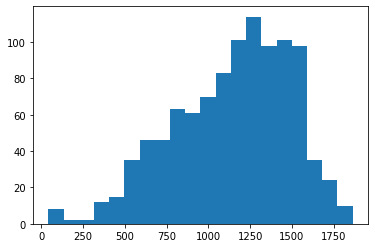

In [40]:
kmer_v = [kmer_counts[c] for c in kmer_counts]
plt.hist(kmer_v, bins=20)

In [45]:
count_df_nn

,gene,id,gene,gene_biotype,SRR12090435,SRR12090430,SRR12090427,SRR12090432,SRR12090426,SRR12090433,SRR12090429,SRR12090434,SRR12090431,SRR12090428
5,gene-b0946,NC_000913.3:1005951-1006494,zapC,protein_coding,34,27,51,45,33,58,17,42,66,33
6,gene-b0947,NC_000913.3:1006490-1007600,ycbX,protein_coding,14,6,26,17,9,23,8,14,29,16
7,gene-b0091,NC_000913.3:100764-102240,murC,protein_coding,63,71,125,90,78,104,51,96,99,91
8,gene-b0948,NC_000913.3:1007843-1009952,rlmL,protein_coding,30,10,35,26,13,40,11,25,30,25
9,gene-b0949,NC_000913.3:1009963-1011871,uup,protein_coding,26,12,38,33,13,51,5,29,30,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,gene-b0930,NC_000913.3:987584-988985,asnS,protein_coding,254,57,181,171,57,298,43,202,323,157
4483,gene-b0931,NC_000913.3:989153-990356,pncB,protein_coding,35,16,63,15,20,46,14,27,57,48
4484,gene-b0932,NC_000913.3:990621-993234,pepN,protein_coding,167,230,265,212,220,241,124,209,233,180
4485,gene-b0010,NC_000913.3:9927-10494,satP,protein_coding,19,9,20,14,6,34,2,11,30,19


In [43]:
kmers_to_investigate = []
for k in kmer_counts:
    if kmer_counts[k] > 100:
        kmers_to_investigate.append(k)
print(len(kmers_to_investigate))

training_runs = []
for bam in bams:
    training_runs.append(f'{output_folder}training_new/{bam.split("/")[-1].split(".")[0]}_training.h5')
training_runs

1018


In [ ]:
import pandas as pd
from scibacr import *
import itertools
from scipy import stats
from statsmodels.stats.multitest import multipletests


e_plus_ecoli = ['SRR12090426', 'SRR12090427', 'SRR12090428']
e_minus_ecoli = ['SRR12090429', 'SRR12090430']
s_plus_ecoli = ['SRR12090431', 'SRR12090432', 'SRR12090433']
s_minus_ecoli = ['SRR12090434', 'SRR12090435']

cond_dict = {'SRR12090426': 'e-plus-ecoli', 'SRR12090427': 'e-plus-ecoli', 'SRR12090428': 'e-plus-ecoli',
            'SRR12090429': 'e-minus-ecoli', 'SRR12090430': 'e-minus-ecoli', 
             'SRR12090431': 's-plus-ecoli', 'SRR12090432': 's-plus-ecoli', 'SRR12090433': 's-plus-ecoli',
             'SRR12090434': 's-minus-ecoli', 'SRR12090435': 's-minus-ecoli'
            }
exp_name = 'ecoli'
comparisons = list(itertools.combinations(species_runs, 2))
all_dfs = pd.DataFrame()
# Check for significance between kmers
for kmer_name in kmers_to_investigate:
    p_values = []
    t_values = []
    labels = []
    kmers = []
    condlabels = []
    kmer_label = []

    df_kmer = get_kmer_encodings(kmer_name,  f'{output_folder}kmer_5_bac.h5', training_runs, 100)
    df_psi = df_kmer

    df_psi.fillna(0, inplace=True)

    # encode the data
    psi_data = df_psi.values[:, 5:]
    psi_data = psi_data / np.max(psi_data)
    psi_data = np.array(psi_data).astype(float)
    psi_data = np.array([d.reshape((4, kmer_len, 1)) for d in psi_data])
    seqs_encoding = cvae.encode_new_data(psi_data, scale=False)
    df_psi['MeanEncoding'] = seqs_encoding

    for kmer_start in set(df_kmer['ID'].values):
        df_psi_kmer = df_psi[df_psi['Start'] == kmer_start]
        if len(df_psi_kmer) > 10:
            for comparison in comparisons:
                e_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[0]}_training']['MeanEncoding'].values
                s_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[1]}_training']['MeanEncoding'].values
                if len(e_plus) > 5 and len(s_plus) > 5:
                    t_stat, p_val = stats.ttest_ind(e_plus, s_plus)
                    p_values.append(p_val)
                    t_values.append(t_stat)
                    kmers.append(kmer_start)
                    labels.append(f'{comparison[1]} vs {comparison[0]}')
                    condlabels.append(f'{cond_dict[comparison[1]]} vs {cond_dict[comparison[0]]}')
    # Calculate adjusted p-values
    p_adj = multipletests(p_values, alpha=0.1, method='fdr_bh', returnsorted=False)

    kmer_df = pd.DataFrame()
    kmer_df['p_values'] = p_adj[1]
    kmer_df['p.adj'] = p_values
    kmer_df['t_values'] = t_values
    kmer_df['labels'] = labels
    kmer_df['kmer'] = kmers
    kmer_df['kmer_name'] = kmer_label
    all_dfs = all_dfs.append(kmer_df)
    kmer_df.to_csv(f'{output_folder}kmers/KMER_{kmer_name}_{exp_name}.csv', index=False)

100%|█| 1378/1378 [05:20<00:00,  4.30i


../runs/training_new/SRR12090435_training.h5 112507


100%|█| 1378/1378 [05:20<00:00,  4.30i


../runs/training_new/SRR12090430_training.h5 207046


100%|█| 1378/1378 [07:15<00:00,  3.16i


../runs/training_new/SRR12090427_training.h5 371211


100%|█| 1378/1378 [04:04<00:00,  5.64i


../runs/training_new/SRR12090432_training.h5 470227


100%|█| 1378/1378 [04:59<00:00,  4.60i


../runs/training_new/SRR12090426_training.h5 575241


100%|█| 1378/1378 [05:46<00:00,  3.97i


../runs/training_new/SRR12090433_training.h5 715888


100%|█| 1378/1378 [


../runs/training_new/SRR12090429_training.h5 791992


100%|█| 1378/1378 [


../runs/training_new/SRR12090434_training.h5 887679


100%|█| 1378/1378 [


../runs/training_new/SRR12090431_training.h5 1027623


100%|█| 1378/1378 [


../runs/training_new/SRR12090428_training.h5 1165684
36428/36428 [==============================] - 43s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1577/1577 [


../runs/training_new/SRR12090435_training.h5 111657


100%|█| 1577/1577 [


../runs/training_new/SRR12090430_training.h5 210166


100%|█| 1577/1577 [


../runs/training_new/SRR12090427_training.h5 369577


100%|█| 1577/1577 [


../runs/training_new/SRR12090432_training.h5 468392


100%|█| 1577/1577 [


../runs/training_new/SRR12090426_training.h5 575942


100%|█| 1577/1577 [


../runs/training_new/SRR12090433_training.h5 712505


100%|█| 1577/1577 [


../runs/training_new/SRR12090429_training.h5 791738


100%|█| 1577/1577 [


../runs/training_new/SRR12090434_training.h5 888578


100%|█| 1577/1577 [


../runs/training_new/SRR12090431_training.h5 1024599


100%|█| 1577/1577 [


../runs/training_new/SRR12090428_training.h5 1160942
36280/36280 [==============================] - 44s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1260/1260 [


../runs/training_new/SRR12090435_training.h5 68287


100%|█| 1260/1260 [


../runs/training_new/SRR12090430_training.h5 126011


100%|█| 1260/1260 [


../runs/training_new/SRR12090427_training.h5 223904


100%|█| 1260/1260 [


../runs/training_new/SRR12090432_training.h5 285203


100%|█| 1260/1260 [


../runs/training_new/SRR12090426_training.h5 348944


100%|█| 1260/1260 [


../runs/training_new/SRR12090433_training.h5 434524


100%|█| 1260/1260 [


../runs/training_new/SRR12090429_training.h5 480536


100%|█| 1260/1260 [


../runs/training_new/SRR12090434_training.h5 540046


100%|█| 1260/1260 [


../runs/training_new/SRR12090431_training.h5 625388


100%|█| 1260/1260 [


../runs/training_new/SRR12090428_training.h5 707598
22113/22113 [==============================] - 26s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1510/1510 [


../runs/training_new/SRR12090435_training.h5 91773


100%|█| 1510/1510 [


../runs/training_new/SRR12090430_training.h5 170850


100%|█| 1510/1510 [


../runs/training_new/SRR12090427_training.h5 303647


100%|█| 1510/1510 [


../runs/training_new/SRR12090432_training.h5 384373


100%|█| 1510/1510 [


../runs/training_new/SRR12090426_training.h5 470963


100%|█| 1510/1510 [


../runs/training_new/SRR12090433_training.h5 586283


100%|█| 1510/1510 [


../runs/training_new/SRR12090429_training.h5 650231


100%|█| 1510/1510 [


../runs/training_new/SRR12090434_training.h5 728980


100%|█| 1510/1510 [


../runs/training_new/SRR12090431_training.h5 844469


100%|█| 1510/1510 [


../runs/training_new/SRR12090428_training.h5 955607
29863/29863 [==============================] - 36s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1406/1406 [


../runs/training_new/SRR12090435_training.h5 79851


100%|█| 1406/1406 [


../runs/training_new/SRR12090430_training.h5 150717


100%|█| 1406/1406 [


../runs/training_new/SRR12090427_training.h5 263897


100%|█| 1406/1406 [


../runs/training_new/SRR12090432_training.h5 336395


100%|█| 1406/1406 [


../runs/training_new/SRR12090426_training.h5 412202


100%|█| 1406/1406 [


../runs/training_new/SRR12090433_training.h5 510094


100%|█| 1406/1406 [


../runs/training_new/SRR12090429_training.h5 567245


100%|█| 1406/1406 [


../runs/training_new/SRR12090434_training.h5 638882


100%|█| 1406/1406 [


../runs/training_new/SRR12090431_training.h5 736539


100%|█| 1406/1406 [


../runs/training_new/SRR12090428_training.h5 833897
26060/26060 [==============================] - 31s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1576/1576 [


../runs/training_new/SRR12090435_training.h5 109686


100%|█| 1576/1576 [


../runs/training_new/SRR12090430_training.h5 208535


100%|█| 1576/1576 [


../runs/training_new/SRR12090427_training.h5 362071


100%|█| 1576/1576 [


../runs/training_new/SRR12090432_training.h5 460101


100%|█| 1576/1576 [


../runs/training_new/SRR12090426_training.h5 566689


100%|█| 1576/1576 [


../runs/training_new/SRR12090433_training.h5 698481


100%|█| 1576/1576 [


../runs/training_new/SRR12090429_training.h5 779096


100%|█| 1576/1576 [


../runs/training_new/SRR12090434_training.h5 876041


100%|█| 1576/1576 [


../runs/training_new/SRR12090431_training.h5 1007760


100%|█| 1576/1576 [


../runs/training_new/SRR12090428_training.h5 1140244
35633/35633 [==============================] - 43s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1572/1572 [


../runs/training_new/SRR12090435_training.h5 107704


100%|█| 1572/1572 [


../runs/training_new/SRR12090430_training.h5 202046


100%|█| 1572/1572 [


../runs/training_new/SRR12090427_training.h5 353720


100%|█| 1572/1572 [


../runs/training_new/SRR12090432_training.h5 449852


100%|█| 1572/1572 [


../runs/training_new/SRR12090426_training.h5 553562


100%|█| 1572/1572 [


../runs/training_new/SRR12090433_training.h5 685297


100%|█| 1572/1572 [


../runs/training_new/SRR12090429_training.h5 761630


100%|█| 1572/1572 [


../runs/training_new/SRR12090434_training.h5 856115


100%|█| 1572/1572 [


../runs/training_new/SRR12090431_training.h5 987290


100%|█| 1572/1572 [


../runs/training_new/SRR12090428_training.h5 1117307
34916/34916 [==============================] - 42s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1328/1328 [


../runs/training_new/SRR12090435_training.h5 80921


100%|█| 1328/1328 [


../runs/training_new/SRR12090430_training.h5 151400


100%|█| 1328/1328 [


../runs/training_new/SRR12090427_training.h5 261048


100%|█| 1328/1328 [


../runs/training_new/SRR12090432_training.h5 334306


100%|█| 1328/1328 [


../runs/training_new/SRR12090426_training.h5 410983


100%|█| 1328/1328 [


../runs/training_new/SRR12090433_training.h5 508155


100%|█| 1328/1328 [


../runs/training_new/SRR12090429_training.h5 565532


100%|█| 1328/1328 [


../runs/training_new/SRR12090434_training.h5 637263


100%|█| 1328/1328 [


../runs/training_new/SRR12090431_training.h5 734343


100%|█| 1328/1328 [0


../runs/training_new/SRR12090428_training.h5 830585
25956/25956 [==============================] - 31s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1343/1343 [0


../runs/training_new/SRR12090430_training.h5 180811


100%|█| 1343/1343 [0


../runs/training_new/SRR12090427_training.h5 310248


100%|█| 1343/1343 [0


../runs/training_new/SRR12090432_training.h5 395369


 73%|▋| 985/1343 [03IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1548/1548 [0


../runs/training_new/SRR12090427_training.h5 368063


100%|█| 1548/1548 [0


../runs/training_new/SRR12090432_training.h5 469776


100%|█| 1548/1548 [0


../runs/training_new/SRR12090426_training.h5 577920


 50%|▍| 770/1548 [03IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1193/1193 [0


../runs/training_new/SRR12090427_training.h5 220265


100%|█| 1193/1193 [0


../runs/training_new/SRR12090432_training.h5 279800


100%|█| 1193/1193 [0


../runs/training_new/SRR12090426_training.h5 345503


100%|█| 1193/1193 [0


../runs/training_new/SRR12090433_training.h5 426030


100%|█| 1193/1193 [0


../runs/training_new/SRR12090429_training.h5 475940


 24%|▏| 286/1193 [01IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1277/1277 [0


../runs/training_new/SRR12090433_training.h5 468619


100%|█| 1277/1277 [0


../runs/training_new/SRR12090429_training.h5 521205


100%|█| 1277/1277 [0


../runs/training_new/SRR12090434_training.h5 587601


100%|█| 1277/1277 [0


../runs/training_new/SRR12090431_training.h5 678056


 66%|▋| 846/1277 [04IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1138/1138 [0


../runs/training_new/SRR12090428_training.h5 571791
17869/17869 [==============================] - 22s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1526/1526 [0


../runs/training_new/SRR12090435_training.h5 96986


100%|█| 1526/1526 [0


../runs/training_new/SRR12090430_training.h5 181263


 50%|▌| 764/1526 [03IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31241/31241 [==============================] - 38s 1ms/step


/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1312/1312 [0


../runs/training_new/SRR12090435_training.h5 70678


100%|█| 1312/1312 [0


../runs/training_new/SRR12090430_training.h5 133830


 94%|▉| 1234/1312 [0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1312/1312 [0


../runs/training_new/SRR12090428_training.h5 737481
15121/23047 [==================>...........] - ETA: 9s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1347/1347 [0


../runs/training_new/SRR12090427_training.h5 226437


100%|█| 1347/1347 [0


../runs/training_new/SRR12090432_training.h5 287166


100%|█| 1347/1347 [0


../runs/training_new/SRR12090426_training.h5 352610


 25%|▎| 342/1347 [01IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1373/1373 [0


../runs/training_new/SRR12090435_training.h5 84801


 62%|▌| 845/1373 [02IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1373/1373 [0


../runs/training_new/SRR12090432_training.h5 352388


100%|█| 1373/1373 [0


../runs/training_new/SRR12090426_training.h5 433206


100%|█| 1373/1373 [0


../runs/training_new/SRR12090433_training.h5 535146


 56%|▌| 770/1373 [01IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1152/1152 [0


../runs/training_new/SRR12090430_training.h5 121672


 75%|▊| 864/1152 [04IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1152/1152 [0


../runs/training_new/SRR12090433_training.h5 402878


100%|█| 1152/1152 [0


../runs/training_new/SRR12090429_training.h5 451175


100%|█| 1152/1152 [0


../runs/training_new/SRR12090434_training.h5 507892


100%|█| 1152/1152 [0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1489/1489 [0


../runs/training_new/SRR12090432_training.h5 436689


 70%|▋| 1041/1489 [0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1489/1489 [0


../runs/training_new/SRR12090429_training.h5 738214


100%|█| 1489/1489 [0


../runs/training_new/SRR12090434_training.h5 833080


100%|█| 1489/1489 [0


../runs/training_new/SRR12090431_training.h5 960058


 29%|▎| 437/1489 [01IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1278/1278 [0


../runs/training_new/SRR12090426_training.h5 367162


 23%|▏| 296/1278 [01IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1278/1278 [0


../runs/training_new/SRR12090431_training.h5 656859


100%|█| 1278/1278 [0


../runs/training_new/SRR12090428_training.h5 740729
23148/23148 [==============================] - 28s 1ms/step


/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
 16%|▏| 245/1499 [00IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1499/1499 [0


../runs/training_new/SRR12090433_training.h5 721421


100%|█| 1499/1499 [0


../runs/training_new/SRR12090429_training.h5 805430


100%|█| 1499/1499 [0


../runs/training_new/SRR12090434_training.h5 909164


 59%|▌| 887/1499 [04IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1108/1108 [0


../runs/training_new/SRR12090429_training.h5 393828


100%|█| 1108/1108 [0


../runs/training_new/SRR12090434_training.h5 443766


100%|█| 1108/1108 [0


../runs/training_new/SRR12090431_training.h5 511152


100%|█| 1108/1108 [0


../runs/training_new/SRR12090428_training.h5 577185
18038/18038 [==============================] - 22s 1ms/step


/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
 15%|▏| 225/1531 [00IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1531/1531 [0


../runs/training_new/SRR12090434_training.h5 948839


100%|█| 1531/1531 [0


../runs/training_new/SRR12090431_training.h5 1090602


100%|█| 1531/1531 [0


../runs/training_new/SRR12090428_training.h5 1233597
22079/38550 [================>.............] - ETA: 20s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1197/1197 [0


../runs/training_new/SRR12090431_training.h5 641784


100%|█| 1197/1197 [0


../runs/training_new/SRR12090428_training.h5 725818
22682/22682 [==============================] - 27s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1255/1255 [0


../runs/training_new/SRR12090435_training.h5 76585


 82%|▊| 1028/1255 [0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24884/24884 [==============================] - 31s 1ms/step


/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 1680/1680 [0


../runs/training_new/SRR12090435_training.h5 144859


100%|█| 1680/1680 [0


../runs/training_new/SRR12090430_training.h5 270755


 64%|▋| 1081/1680 [0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 1680/1680 [0


../runs/training_new/SRR12090427_training.h5 469634


100%|█| 


../runs/training_new/SRR12090432_training.h5 599942


100%|█| 


../runs/training_new/SRR12090426_training.h5 738112


100%|█| 


../runs/training_new/SRR12090433_training.h5 913181


100%|█| 


../runs/training_new/SRR12090429_training.h5 1015463


100%|█| 


../runs/training_new/SRR12090434_training.h5 1142802


100%|█| 


../runs/training_new/SRR12090431_training.h5 1318132


100%|█| 


../runs/training_new/SRR12090428_training.h5 1489920
46560/46560 [==============================] - 58s 1ms/step


/tmp/ipykernel_1216511/2794221992.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR12090435_training.h5 101326


100%|█| 


../runs/training_new/SRR12090430_training.h5 191449


100%|█| 


../runs/training_new/SRR12090427_training.h5 326933


 16%|▏| 